# **Part 3**

**Part 3.1**

Importing libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Data Loading & Preprocessing

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 52.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.04MB/s]


Stratified data reduction

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Convert MNIST training dataset to numpy arrays once
X_all = train_dataset.data.numpy()
y_all = train_dataset.targets.numpy()

# Take a stratified subset (e.g., 10% of the training data)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
train_idx, _ = next(splitter.split(X_all, y_all))

X_subset = X_all[train_idx]
y_subset = y_all[train_idx]

# Create new smaller TensorDataset
subset_tensor = torch.utils.data.TensorDataset(
    torch.tensor(X_subset).unsqueeze(1).float() / 255.0,
    torch.tensor(y_subset)
)

# Dataloaders (smaller train set, full test set)
train_loader = DataLoader(subset_tensor, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)


Convert loaders → numpy

In [5]:
def dataloader_to_numpy(loader):
    X, y = [], []
    for xb, yb in loader:
        X.append(xb.view(xb.size(0), -1).numpy())
        y.append(yb.numpy())
    return np.vstack(X), np.concatenate(y)

X_train, y_train = dataloader_to_numpy(train_loader)
X_test, y_test   = dataloader_to_numpy(test_loader)

MLP model

Epoch 0 Avg Loss: 2.3048
Epoch 50 Avg Loss: 0.1516
Epoch 100 Avg Loss: 0.0270
Epoch 150 Avg Loss: 0.0095
Epoch 200 Avg Loss: 0.0035
Epoch 250 Avg Loss: 0.0022
Epoch 300 Avg Loss: 0.0017
Epoch 350 Avg Loss: 0.0015
Epoch 400 Avg Loss: 0.0013
Epoch 450 Avg Loss: 0.0012

Accuracy: 0.2750999927520752 

              precision    recall  f1-score   support

           0     0.3046    0.8724    0.4515       980
           1     0.0435    0.0044    0.0080      1135
           2     0.9000    0.0262    0.0508      1032
           3     1.0000    0.0040    0.0079      1010
           4     0.2967    0.6232    0.4020       982
           5     0.6667    0.0045    0.0089       892
           6     0.1863    0.7557    0.2989       958
           7     0.4877    0.4825    0.4851      1028
           8     0.0000    0.0000    0.0000       974
           9     0.3333    0.0238    0.0444      1009

    accuracy                         0.2751     10000
   macro avg     0.4219    0.2797    0.1758     100

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


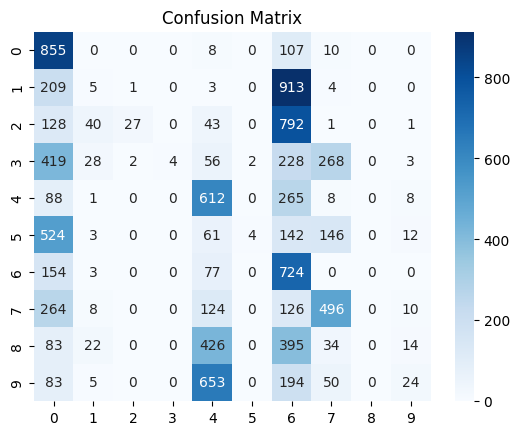

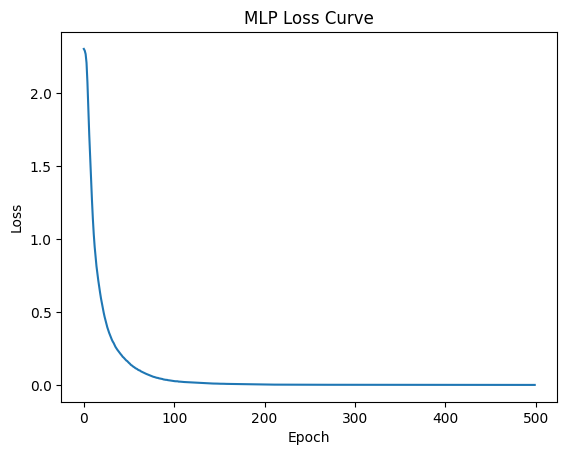

In [12]:
class MLP(nn.Module):
    def __init__(self, act=nn.ReLU()):
        super().__init__()
        self.act = act
        self.l1 = nn.Linear(28*28, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.act(self.l3(x))
        x = self.l4(x)
        return x
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

model_mlp = MLP(act=nn.Sigmoid())
losses_mlp = train(model_mlp, lr=1e-3, epochs=500, reg=1e-5)
cm_mlp = print_metrics(model_mlp)

plt.plot(losses_mlp)
plt.title("MLP Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Logistic Regression Model

In [7]:
class LogisticRegressionTorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28 * 28, 10)
    def forward(self, x):
        return self.linear(x)
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

Epoch 0 Avg Loss: 2.2393
Epoch 50 Avg Loss: 0.5121
Epoch 100 Avg Loss: 0.3672
Epoch 150 Avg Loss: 0.3058
Epoch 200 Avg Loss: 0.2682
Epoch 250 Avg Loss: 0.2435
Epoch 300 Avg Loss: 0.2235
Epoch 350 Avg Loss: 0.2067
Epoch 400 Avg Loss: 0.1943
Epoch 450 Avg Loss: 0.1817

Accuracy: 0.34940001368522644 

              precision    recall  f1-score   support

           0     0.9528    0.5969    0.7340       980
           1     0.3820    0.9982    0.5525      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.2856    0.9827    0.4426       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     1.0000    0.0021    0.0041       974
           9     0.2663    0.8018    0.3998      1009

    accuracy                         0.3494     10000
   macro avg     0.2887    0.3382    0.2133     10

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


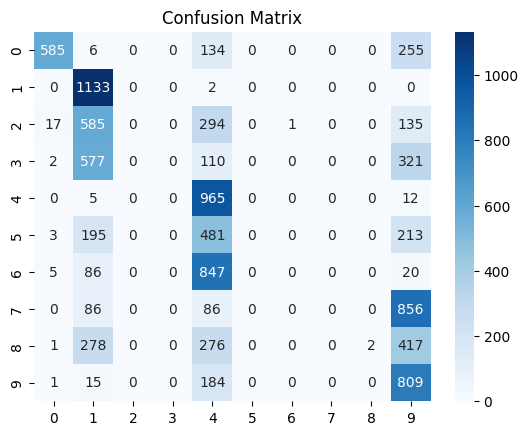

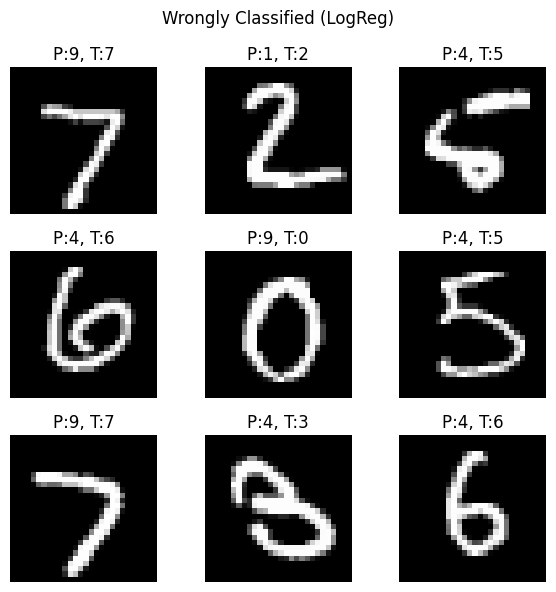

In [8]:
def train(model, lr=3e-4, epochs=2000, reg=0):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for xb, yb in train_loader:
            xb = xb.view(xb.size(0), -1)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if epoch % 50 == 0:
            print(f"Epoch {epoch} Avg Loss: {avg_loss:.4f}")
    return losses

def print_metrics(model):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.view(xb.size(0), -1)
            preds.append(model(xb).argmax(1))
            trues.append(yb)
    preds = torch.cat(preds)
    trues = torch.cat(trues)
    acc = (preds == trues).float().mean().item()
    cm = confusion_matrix(trues, preds)
    print("\nAccuracy:", acc,'\n')
    print(classification_report(trues, preds, digits=4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    return cm

# Train Logistic Regression
model_lr = LogisticRegressionTorch()
losses_lr = train(model_lr, lr=3e-4, epochs=500)
cm_lr = print_metrics(model_lr)

# Show wrongly classified samples
test_X = torch.tensor(X_test).float()
test_y = torch.tensor(y_test)
pred = model_lr.predict(test_X)
wrong = test_X[pred != test_y]
wrong_pred = pred[pred != test_y]
wrong_true = test_y[pred != test_y]

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(wrong[i * 3 + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f"P:{wrong_pred[i*3+j]}, T:{wrong_true[i*3+j]}")
        ax[i, j].axis('off')
plt.suptitle("Wrongly Classified (LogReg)")
plt.tight_layout()
plt.show()

RF acc: 0.9037
              precision    recall  f1-score   support

           0     0.9489    0.9673    0.9581       980
           1     0.9029    0.9912    0.9450      1135
           2     0.9406    0.8740    0.9061      1032
           3     0.8863    0.8950    0.8906      1010
           4     0.8887    0.9267    0.9073       982
           5     0.8366    0.8957    0.8652       892
           6     0.9477    0.9269    0.9372       958
           7     0.8359    0.9465    0.8878      1028
           8     0.9674    0.7628    0.8530       974
           9     0.9106    0.8375    0.8725      1009

    accuracy                         0.9037     10000
   macro avg     0.9066    0.9024    0.9023     10000
weighted avg     0.9068    0.9037    0.9030     10000



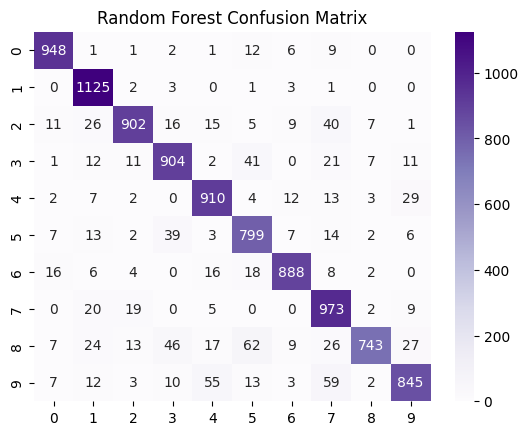

In [9]:
rf = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RF acc:", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf, digits=4))
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d', cmap='Purples')
plt.title("Random Forest Confusion Matrix")
plt.show()

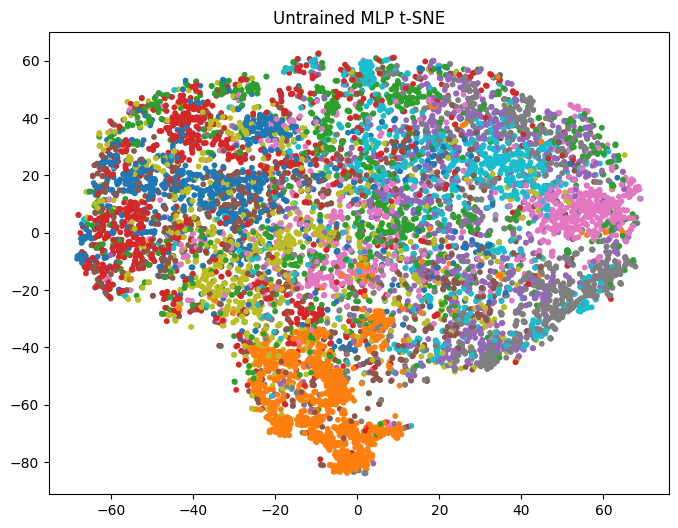

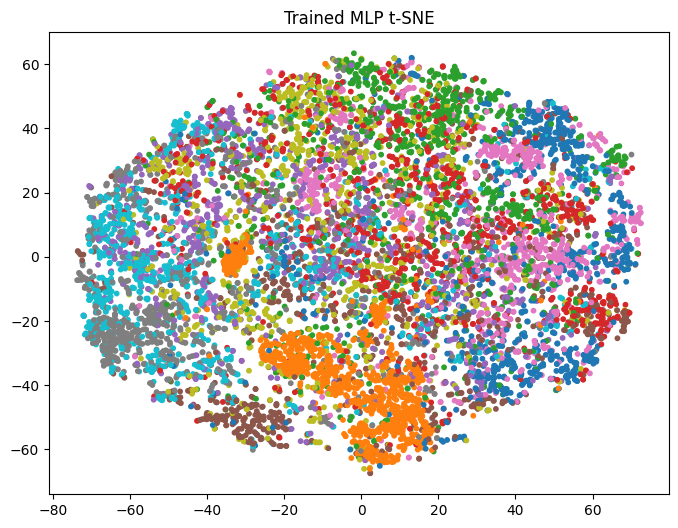

In [10]:
def plot_tsne(model, title):
    with torch.no_grad():
        embeddings = []
        for xb, yb in test_loader:
            xb = xb.view(xb.size(0), -1)
            feats = model.forward(xb)
            embeddings.append(feats)
        embeddings = torch.cat(embeddings).numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=40)
    X_emb = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_emb[:,0], X_emb[:,1], c=y_test, cmap='tab10', s=10)
    plt.title(title)
    plt.show()

plot_tsne(MLP(), "Untrained MLP t-SNE")
plot_tsne(model_mlp, "Trained MLP t-SNE")

In [11]:
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
f_loader = DataLoader(fashion_test, batch_size=256, shuffle=False)

f_X, f_y = dataloader_to_numpy(f_loader)
f_X = torch.tensor(f_X).float()

pred_fashion = model_mlp.predict(f_X)
acc_fashion = (pred_fashion == torch.tensor(f_y)).float().mean().item()
print("Fashion-MNIST Accuracy (using MNIST-trained MLP):", acc_fashion)


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.61MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.0MB/s]


Fashion-MNIST Accuracy (using MNIST-trained MLP): 0.10000000149011612


Part 3.2

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

Data Loading + Stratified Subset

In [14]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_all = train_dataset.data.numpy()
y_all = train_dataset.targets.numpy()

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
train_idx, _ = next(splitter.split(X_all, y_all))

X_subset = X_all[train_idx]
y_subset = y_all[train_idx]

subset_tensor = TensorDataset(
    torch.tensor(X_subset).unsqueeze(1).float() / 255.0,
    torch.tensor(y_subset)
)

train_loader = DataLoader(subset_tensor, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Simple CNN Definition

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 32, 14, 14]
        x = x.view(x.size(0), -1)             # Flatten -> [B, 6272]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Train Function

In [19]:
def train_model(model, train_loader, epochs=5, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = F.cross_entropy(model(xb), yb)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Epoch {epoch} Avg Loss: {total_loss / len(train_loader):.4f}")

Evaluation Function

In [16]:
def evaluate_model(model, test_loader, rgb=False):
    model.eval()
    preds, trues = [], []
    start = time.time()
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            if rgb and xb.shape[1] == 1:
                xb = xb.repeat(1, 3, 1, 1)
            preds.append(model(xb).argmax(1).cpu())
            trues.append(yb.cpu())
    end = time.time()
    preds, trues = torch.cat(preds), torch.cat(trues)

    acc = (preds == trues).float().mean().item()
    f1 = f1_score(trues, preds, average='macro')
    cm = confusion_matrix(trues, preds)

    print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | Inference Time: {end - start:.2f}s")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    return acc, f1, end - start, cm

Epoch 0 Avg Loss: 1.8513
Epoch 1 Avg Loss: 0.9385
Epoch 2 Avg Loss: 0.5327
Epoch 3 Avg Loss: 0.3943
Epoch 4 Avg Loss: 0.3278
Accuracy: 0.9105 | F1 Score: 0.9096 | Inference Time: 4.89s


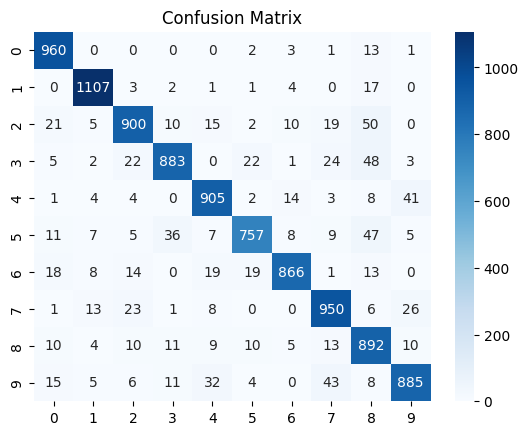

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 97.2MB/s]


Accuracy: 0.1441 | F1 Score: 0.0765 | Inference Time: 20.13s


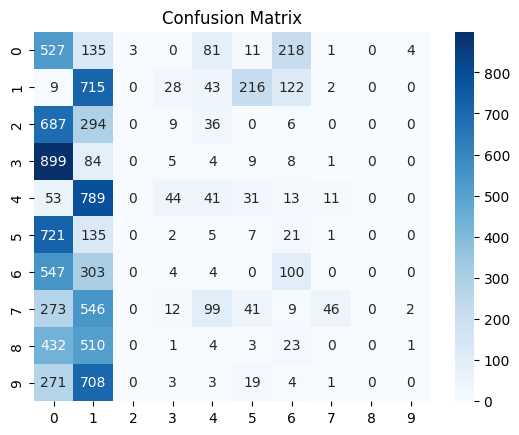

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s] 


Accuracy: 0.0590 | F1 Score: 0.0160 | Inference Time: 49.90s


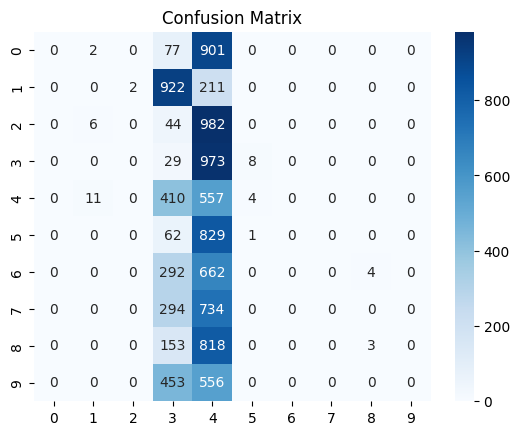


📊 Model Comparison:
Model           Accuracy   F1-score   Time(s)    Params(M) 
SimpleCNN       0.9105     0.9096     4.89       0.80      
MobileNetV2     0.1441     0.0765     20.13      2.24      
EfficientNetB0  0.0590     0.0160     49.90      4.02      


In [20]:
# Run Simple CNN
simple_cnn = SimpleCNN()
train_model(simple_cnn, train_loader, epochs=5, lr=1e-3)
acc1, f1_1, t1, cm1 = evaluate_model(simple_cnn, test_loader)

#Pretrained Models (MobileNet + EfficientNet)
mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1")
mobilenet.classifier[1] = nn.Linear(1280, 10)
mobilenet.to(device)
acc2, f1_2, t2, cm2 = evaluate_model(mobilenet, test_loader, rgb=True)

efficientnet = models.efficientnet_b0(weights="IMAGENET1K_V1")
efficientnet.classifier[1] = nn.Linear(1280, 10)
efficientnet.to(device)
acc3, f1_3, t3, cm3 = evaluate_model(efficientnet, test_loader, rgb=True)

# Comparison Table
print("\n📊 Model Comparison:")
print(f"{'Model':<15} {'Accuracy':<10} {'F1-score':<10} {'Time(s)':<10} {'Params(M)':<10}")
for name, model, acc, f1, t in [
    ("SimpleCNN", simple_cnn, acc1, f1_1, t1),
    ("MobileNetV2", mobilenet, acc2, f1_2, t2),
    ("EfficientNetB0", efficientnet, acc3, f1_3, t3),
]:
    params = sum(p.numel() for p in model.parameters()) / 1e6
    print(f"{name:<15} {acc:<10.4f} {f1:<10.4f} {t:<10.2f} {params:<10.2f}")
